In [9]:
!pip install mediapipe

In [4]:
%pip install -r /content/drive/MyDrive/Project_cdac/requirements.txt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mediapipe as mp
import cv2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import plot_model


In [11]:


# Define the CNN model
def create_model(input_shape, num_classes):
    model = Sequential()

    # CNN layers for spatial feature extraction
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 1)))  # Adjusted pooling size to avoid reducing the dimension to zero
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 1)))  # Adjusted pooling size to avoid reducing the dimension to zero

    # Flatten and fully connected layers for classification
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Example input shape where one dimension is 1
input_shape = (21, 3, 1)  # Adjusted based on the keypoints

# Create the model
num_classes = 29
model = create_model(input_shape, num_classes)

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 21, 3, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 10, 3, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145,565 (568.61 KB)

 Trainable params: 145,565 (568.61 KB)

 Non-trainable params: 0 (0.00 B)

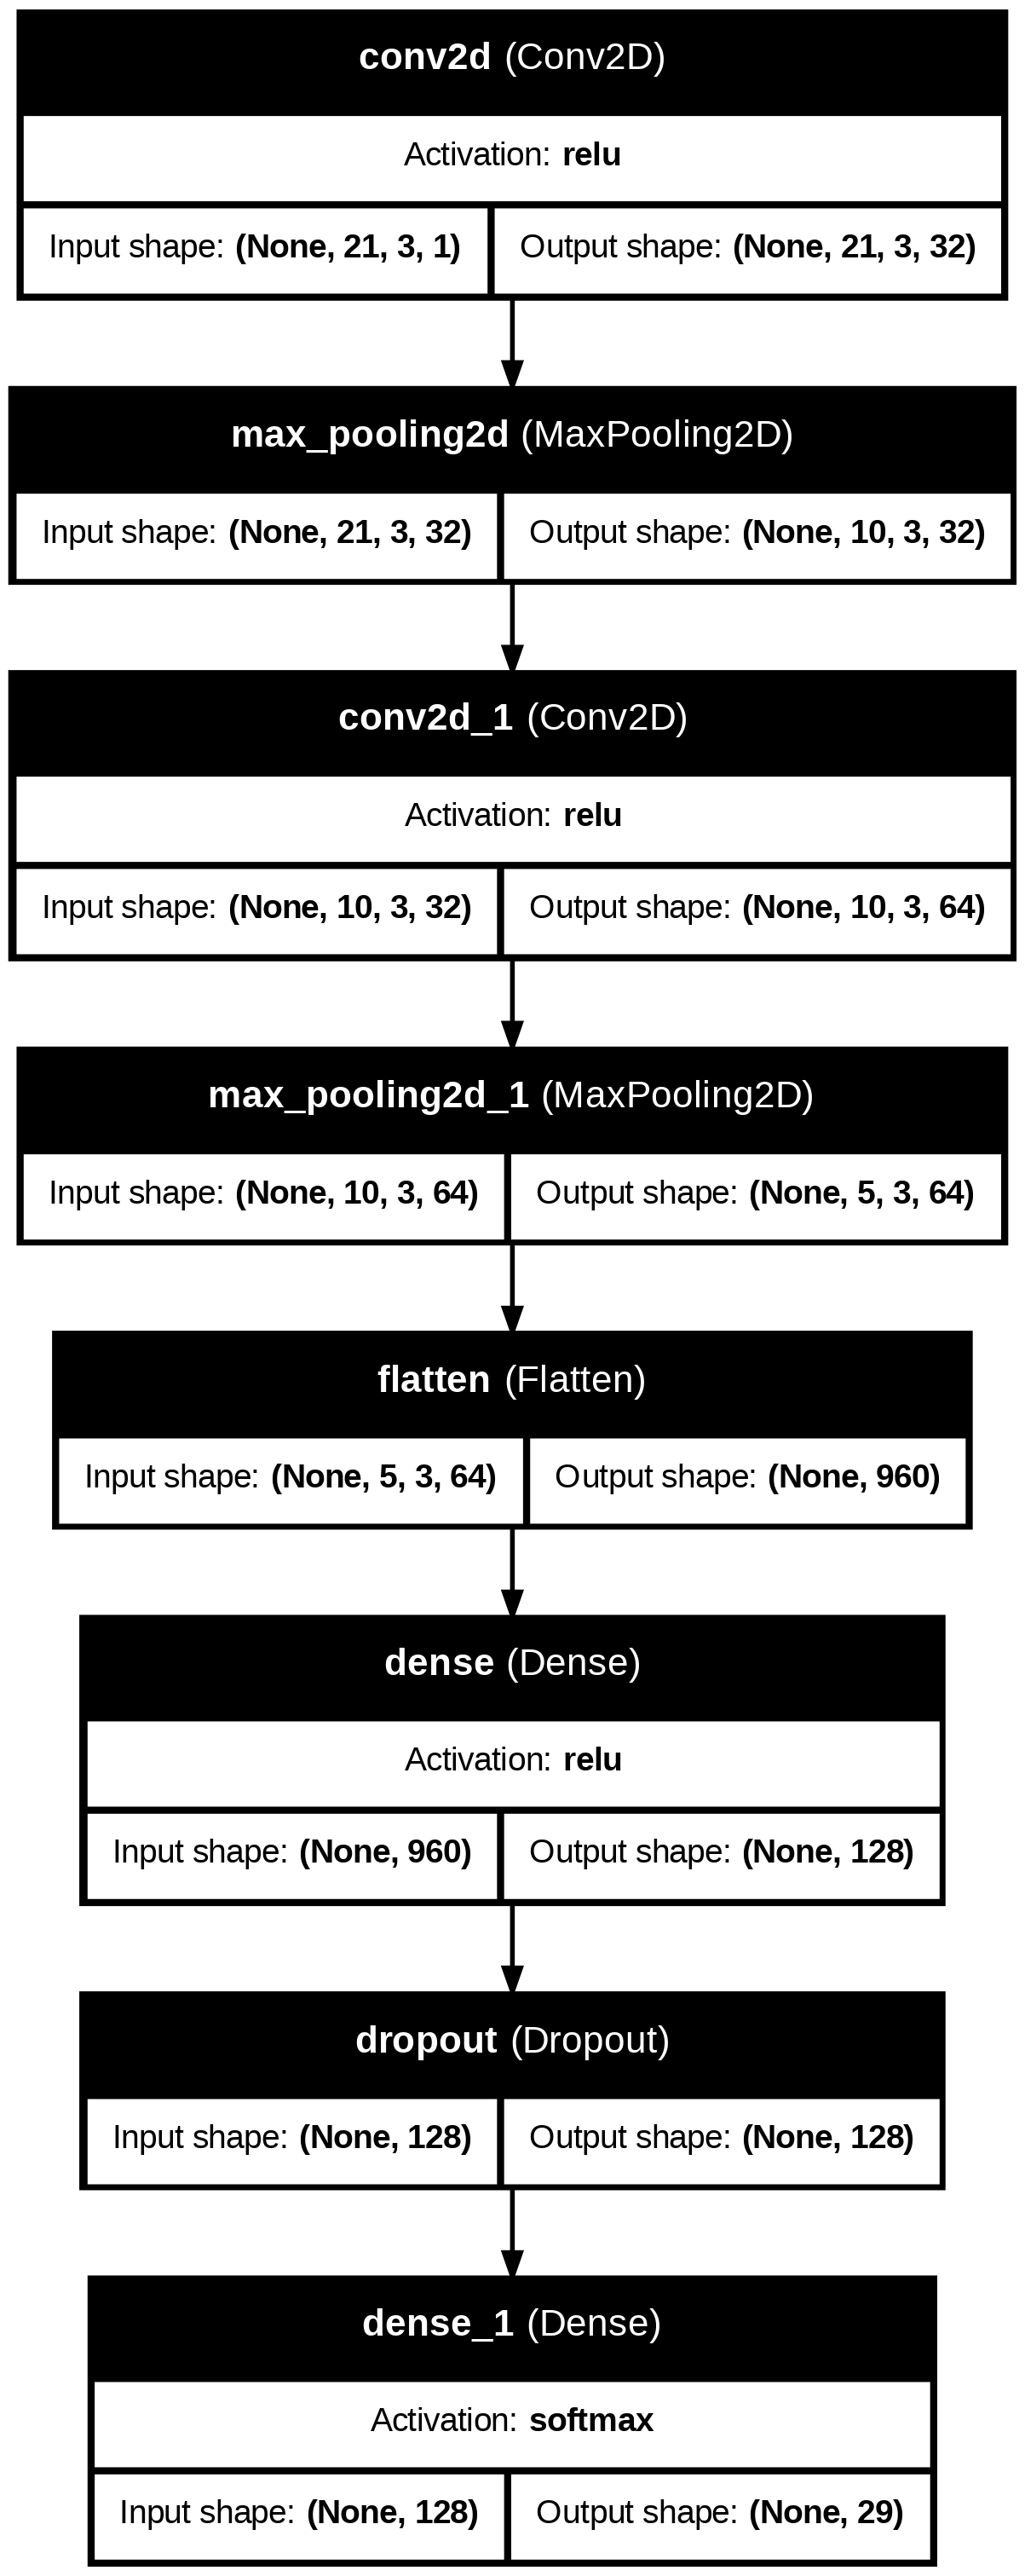

In [12]:
plot_model(model, to_file='/content/drive/MyDrive/Project_cdac/model_architecture.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [13]:

# Function to preprocess hand landmarks for CNN input
def preprocess_landmarks(landmarks):
    # Convert landmarks to a NumPy array
    landmarks_array = np.array([[lm.x, lm.y, lm.z] for lm in landmarks.landmark])

    # Flatten the array
    landmarks_array = landmarks_array.flatten()

    # Normalize the landmarks to be in the range [0, 1]
    landmarks_array = (landmarks_array - np.min(landmarks_array)) / (np.max(landmarks_array) - np.min(landmarks_array))

    # Reshape for CNN input
    return landmarks_array.reshape(21, 3, 1)

In [14]:
# Example data preparation (assuming keypoints are in (21, 3) format)

# # Load your keypoints data (this is just a placeholder)
# X = np.random.rand(87000, 21, 3)  # 21 keypoints, 3 coordinates (x, y, z)
# y = np.random.randint(0, 29, 87000)  # 29 classes


# Load the array back
X = np.load('/content/drive/MyDrive/Project_cdac/X.npy')
y = np.load('/content/drive/MyDrive/Project_cdac/y.npy')

print(X.shape)
print(y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(X_train.shape)
print(X_test.shape)


(63676, 21, 3, 1)
(63676,)
(50940, 21, 3, 1)
(12736, 21, 3, 1)


In [15]:
# Convert labels to categorical
num_classes = 29
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print(y_train.shape)
print(y_test.shape)

(50940, 29)
(12736, 29)


In [16]:
class_labels = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q',
    17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z',
    26: 'space', 27: 'del', 28: 'nothing'
}

# Define the mapping of class labels to their corresponding indices
class_label_indices = {value:key for key, value in class_labels.items()}
print(class_label_indices)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'space': 26, 'del': 27, 'nothing': 28}


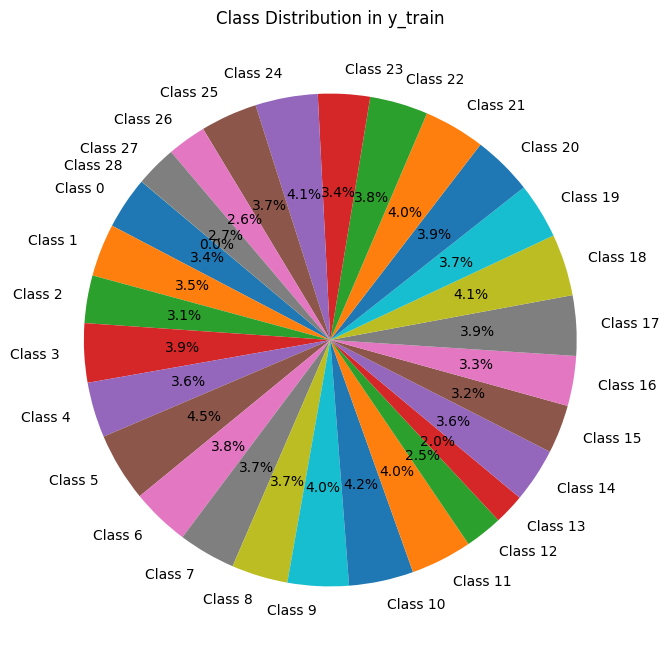

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Example y_train (Replace this with your actual y_train data)
# y_train = np.array([...])

# Count occurrences of each class
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)

# Define class names (optional, if you have specific class names)
class_names = [f'Class {i}' for i in unique]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in y_train')
plt.show()

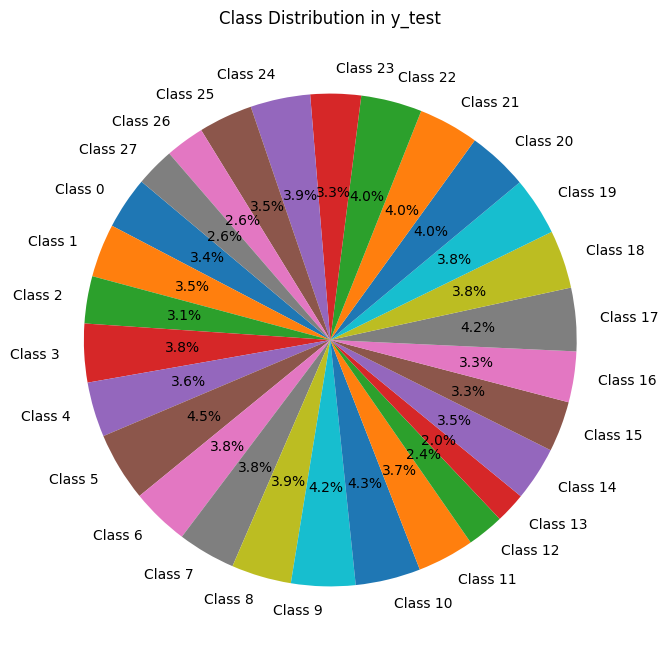

In [18]:


# Example y_train (Replace this with your actual y_train data)
# y_train = np.array([...])

# Count occurrences of each class
unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)

# Define class names (optional, if you have specific class names)
class_names = [f'Class {i}' for i in unique]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in y_test')
plt.show()

In [19]:
# Reshape X data to add the channel dimension (1 for grayscale) - DO THIS ONLY ONCE
# Check if the channel dimension is already present
if X_train.shape[-1] != 1:
    X_train = X_train[..., np.newaxis]
if X_test.shape[-1] != 1:
    X_test = X_test[..., np.newaxis]

# Define model input shape
input_shape = (21, 3, 1)  # (height, width, channels)

# Create the model
model = create_model(input_shape, num_classes)


# # Set up early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32)

# Save the model
model.save('/content/drive/MyDrive/Project_cdac/sign_language_model_no_timesteps.h5')

Epoch 1/200
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.0945 - loss: 3.2094 - val_accuracy: 0.6102 - val_loss: 1.7558
Epoch 2/200
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5010 - loss: 1.6341 - val_accuracy: 0.9013 - val_loss: 0.6539
Epoch 3/200
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7350 - loss: 0.8553 - val_accuracy: 0.9435 - val_loss: 0.3785
Epoch 4/200
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8330 - loss: 0.5678 - val_accuracy: 0.9571 - val_loss: 0.2725
Epoch 5/200
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8806 - loss: 0.4314 - val_accuracy: 0.9640 - val_loss: 0.2225
Epoch 6/200
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9056 - loss: 0.3581 - val_accuracy: 0.9683 - val_loss: 0.1918
Epoch 7/200
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9244 - loss: 0.2960 - val_accuracy: 0.9701 - val_loss: 0.1711
Epoch 8/200
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9354 - loss:

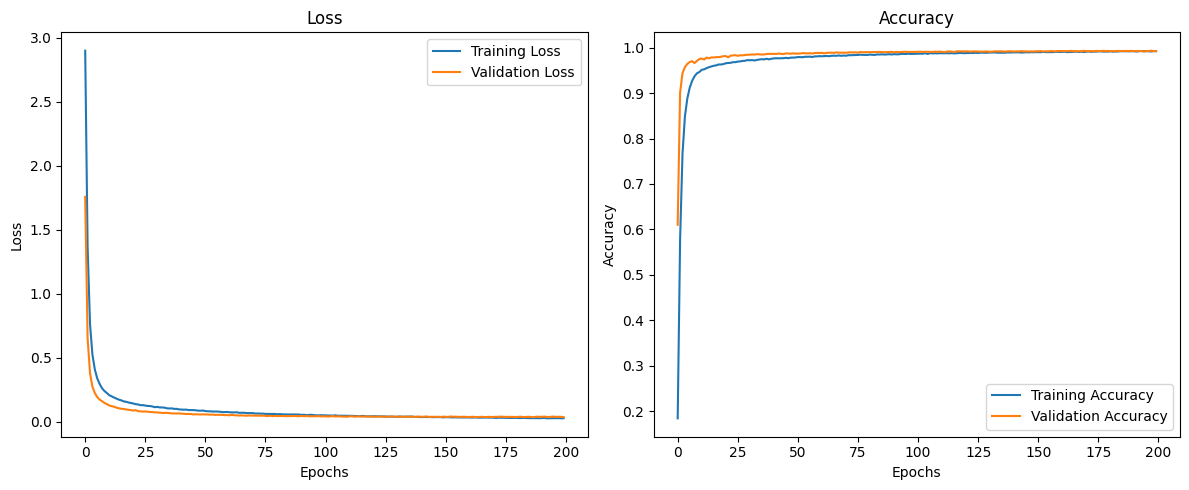

In [20]:
# Plotting Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [21]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


12736/12736 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9914 - loss: 0.0327
Test Accuracy: 99.23%


In [22]:
y_pred = model.predict(X_test, batch_size=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

12736/12736 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


In [23]:
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       438
           1       1.00      1.00      1.00       446
           2       1.00      1.00      1.00       395
           3       0.99      1.00      1.00       489
           4       1.00      0.99      0.99       459
           5       1.00      0.99      1.00       577
           6       1.00      1.00      1.00       485
           7       0.99      0.99      0.99       483
           8       1.00      0.99      0.99       501
           9       1.00      0.99      1.00       536
          10       0.99      0.99      0.99       544
          11       1.00      1.00      1.00       475
          12       0.92      0.98      0.95       308
          13       0.98      0.92      0.95       255
          14       1.00      0.99      0.99       452
          15       1.00      1.00      1.00       422
          16       1.00      1.00      1.00       424
          17       1.00    

<Figure size 1200x800 with 0 Axes>

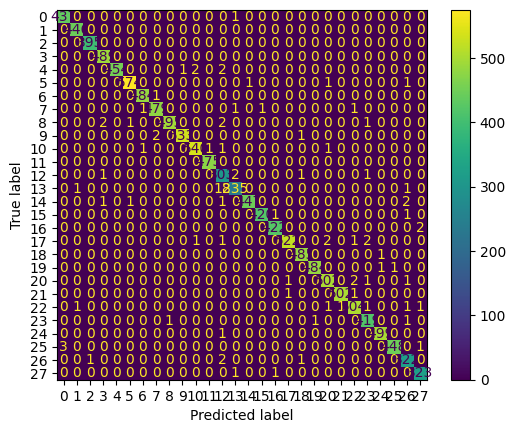

In [24]:
plt.figure(figsize=(12,8))
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create a confusion matrix display with a larger figure size
#fig, ax = plt.subplots(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

In [25]:
# Initialize Mediapipe Hands module
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

# Function to predict sign language gestures in real-time using webcam
def predict_gesture(frame):
    # Convert the frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame to detect hand landmarks
    results = hands.process(rgb_frame)

    # If hand landmarks are detected
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Preprocess the landmarks
            # print(hand_landmarks)
            landmarks_array = preprocess_landmarks(hand_landmarks)

            # Predict the gesture using the trained model
            #model=""
            #print(landmarks_array.shape)
            landmarks_array = landmarks_array.reshape(1, 21, 3, 1)
            prediction = model.predict(landmarks_array)
            #print(prediction)
            predicted_class = np.argmax(prediction)

            # Draw landmarks on the frame
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Display the predicted gesture
            cv2.putText(frame, f'Gesture: {class_labels[predicted_class]}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            #print(class_labels[predicted_class])
            #print(predicted_class)

    return frame

In [26]:
test_path = "/content/drive/MyDrive/Project_cdac/asl_alphabet_test"

for file in os.listdir(test_path):
    if file.endswith(".jpg"):
        frame = cv2.imread(os.path.join(test_path, file))
        frame = predict_gesture(frame)
        cv2.imwrite("/content/drive/MyDrive/Project_cdac/images/test_set/"+file, frame)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
